# Introduction to TaskChain via Example project

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from movie_ratings import config
from taskchain import Config

from pathlib import Path

###  Let's see our source data

In [3]:
!tree {config.DATA_DIR}/source_data

/home/thran/projects/taskchain/example/data/source_data
├── IMDB_movies.csv
└── ratings.Thran.csv

0 directories, 2 files


In [4]:
# path where TaskChain store all data
task_data_path = Path('/tmp/task_data')

## Explore IMDB movies

### 1. start with a config

In [5]:
# all configs in project
!tree {config.CONFIGS_DIR}

/home/thran/projects/taskchain/example/configs
├── features
│   ├── all.yaml
│   └── basic.yaml
├── movies
│   ├── imdb.all.yaml
│   └── imdb.filtered.yaml
└── rating_model
    ├── all_features
    │   ├── baseline.yaml
    │   ├── linear_regression.yaml
    │   ├── nn.yaml
    │   └── tf_linear_regression.yaml
    └── basic_features
        ├── baseline.yaml
        └── linear_regression.yaml

5 directories, 10 files


In [6]:
config_path = config.CONFIGS_DIR / 'movies' / 'imdb.filtered.yaml'

In [7]:
with config_path.open() as f:
    print(f.read())

tasks:
  - movie_ratings.tasks.movies.*

source_file: "{DATA_DIR}/source_data/IMDB_movies.csv"

from_year: 1945
min_vote_count: 1000



#### content of the config

- decleres tasks witch will be part of chain
- and some parametersparameters
    - where take source data
    - movies will be filtered to older then 1945 and with at least 1000 ratings 


### 2. Create chain 

In [8]:
chain = Config(
    task_data_path, # where should by data stored
    config_path,
    global_vars=config,  # set global variables
).chain()
chain.set_log_level('DEBUG')

# show tasks
chain

|                           | name               | group   | namespace   | computed   |
|:--------------------------|:-------------------|:--------|:------------|:-----------|
| movies:all_movies         | all_movies         | movies  |             | True       |
| movies:movies             | movies             | movies  |             | True       |
| movies:movie_names        | movie_names        | movies  |             | False      |
| movies:duration_histogram | duration_histogram | movies  |             | True       |
| movies:year_histogram     | year_histogram     | movies  |             | False      |
| movies:directors          | directors          | movies  |             | True       |
| movies:genres             | genres             | movies  |             | True       |
| movies:countries          | countries          | movies  |             | True       |
| movies:actors             | actors             | movies  |             | True       |

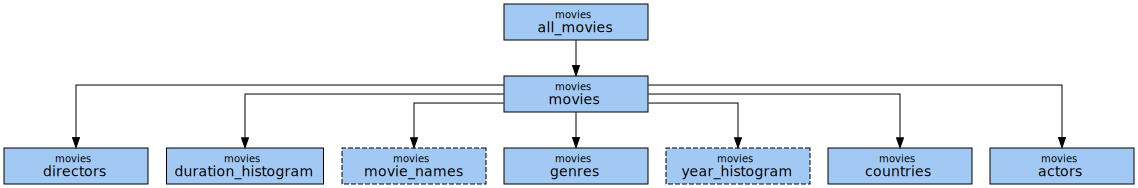

In [9]:
chain.draw()

### 3. Compute and get data 

In [10]:
# access task
chain.duration_histogram

**duration_histogram** 
 - fullname: `movies:duration_histogram` 
 - group: `movies` 
 - config: `imdb.filtered/movies:duration_histogram` 
 - data: `/tmp/task_data/movies/duration_histogram/a1b18bbb1f497f2fa255337f8d9ff81e.pickle` 


In [11]:
# access data
chain.duration_histogram.value

<Figure size 432x288 with 0 Axes>

In [12]:
# we have some data computed !
chain

|                           | name               | group   | namespace   | computed   |
|:--------------------------|:-------------------|:--------|:------------|:-----------|
| movies:all_movies         | all_movies         | movies  |             | True       |
| movies:movies             | movies             | movies  |             | True       |
| movies:movie_names        | movie_names        | movies  |             | False      |
| movies:duration_histogram | duration_histogram | movies  |             | True       |
| movies:year_histogram     | year_histogram     | movies  |             | False      |
| movies:directors          | directors          | movies  |             | True       |
| movies:genres             | genres             | movies  |             | True       |
| movies:countries          | countries          | movies  |             | True       |
| movies:actors             | actors             | movies  |             | True       |

In [13]:
# show some task computation details
chain.duration_histogram.run_info

{'config': {'context': None,
  'name': 'imdb.filtered/movies:duration_histogram',
  'namespace': None},
 'ended': '2021-10-30 14:55:39.556337',
 'input_tasks': {'movies:movies': 'df0ae4cf1dc452b45acd1cee4981c74a'},
 'log': [],
 'parameters': {'max_duration_in_histogram': '240'},
 'started': '2021-10-30 14:55:38.047277',
 'task': {'class': 'DurationHistogram',
  'module': 'movie_ratings.tasks.movies',
  'name': 'movies:duration_histogram'},
 'time': 1.5090601444244385,
 'user': {'name': 'thran', 'taskchain_version': '1.1.1'}}

## Explore models

In [14]:
from taskchain import MultiChain

# with multichain, we can make multiple chains at once
chains = MultiChain.from_dir(
    task_data_path, 
    config.CONFIGS_DIR / 'rating_model' / 'all_features', 
    global_vars=config,
)
chains

multichain:
 - <chain for config `baseline`>
 - <chain for config `linear_regression`>
 - <chain for config `nn`>
 - <chain for config `tf_linear_regression`>

In [15]:
# get a chain - note that some tasks have already computed data from exploring movies
chains['baseline']

|                               | name               | group        | namespace   | computed   |
|:------------------------------|:-------------------|:-------------|:------------|:-----------|
| features:selected_actors      | selected_actors    | features     |             | True       |
| features:selected_directors   | selected_directors | features     |             | True       |
| features:all_features         | all_features       | features     |             | True       |
| features:feature_names        | feature_names      | features     |             | True       |
| features:features             | features           | features     |             |            |
| movies:all_movies             | all_movies         | movies       |             | True       |
| movies:movies                 | movies             | movies       |             | True       |
| movies:genres                 | genres             | movies       |             | True       |
| movies:countries              | countries          | movies       |             | True       |
| movies:actors                 | actors             | movies       |             | True       |
| movies:directors              | directors          | movies       |             | True       |
| movies:movie_names            | movie_names        | movies       |             | False      |
| movies:duration_histogram     | duration_histogram | movies       |             | True       |
| movies:year_histogram         | year_histogram     | movies       |             | False      |
| rating_model:all_x            | all_x              | rating_model |             | True       |
| rating_model:all_y            | all_y              | rating_model |             | True       |
| rating_model:test_movies_mask | test_movies_mask   | rating_model |             | True       |
| rating_model:train_x          | train_x            | rating_model |             | True       |
| rating_model:test_x           | test_x             | rating_model |             | True       |
| rating_model:train_y          | train_y            | rating_model |             | True       |
| rating_model:test_y           | test_y             | rating_model |             | True       |
| rating_model:train_model      | train_model        | rating_model |             | True       |
| rating_model:trained_model    | trained_model      | rating_model |             |            |
| rating_model:test_metrics     | test_metrics       | rating_model |             | True       |

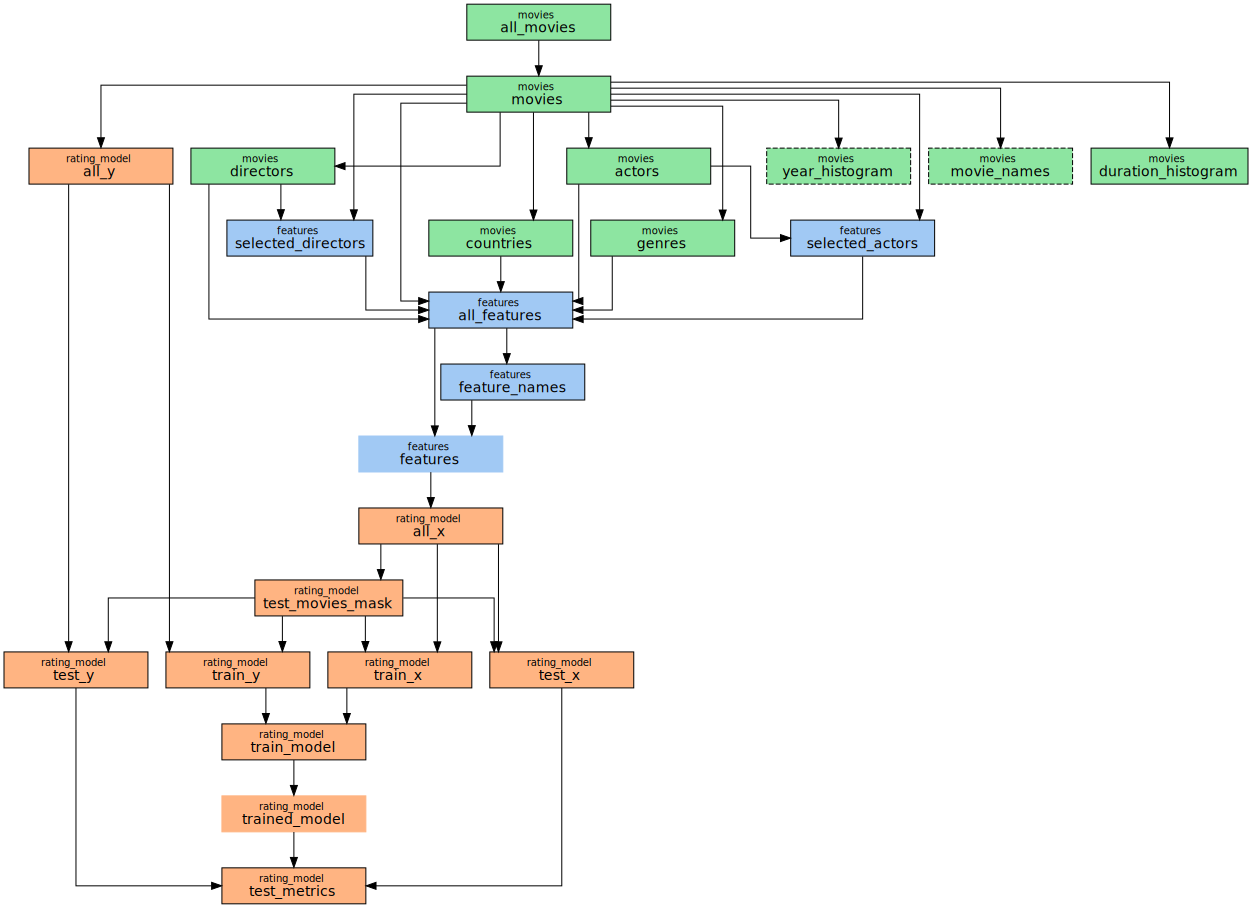

In [16]:
chains['baseline'].draw()

In [17]:
# request test_metrics and trigger computation of all necceserray tasks (feature preparation, model training etc.)
chains['baseline'].test_metrics.value

{'MAE': 0.8731014395283144, 'RMSE': 1.1362462378721352}

In [18]:
# now get metrics for all models - not only training of new models is done, features are already computed and loaded
for name, chain in chains.items():
    _ = chain.test_metrics.value

for name, chain in chains.items():
    print(f'{name:>20}: {chain.test_metrics.value["RMSE"]:.3f} {chain.test_metrics.value["MAE"]:.3f}')


            baseline: 1.136 0.873
   linear_regression: 0.931 0.693
                  nn: 0.978 0.738
tf_linear_regression: 0.916 0.689


## Exercise 

- add own config
    - for movies movies with different filtering - task `all_movies` shoud not be recomputed
    - for models trained only on personal data
        - set `user_rating_file` parameter 
- add own tasks
    - e.g. for analyse ratings per ganres
        - avg
        - histograms
        - the best genre combination
- add own pipeline
    - analyze personal ratings
    - movies as prerequisite to get more data about movies
    - use your imagination on what analasys is interesting
